# Natural Images classifier tutorial 

## 1) Take a look at sample of the data

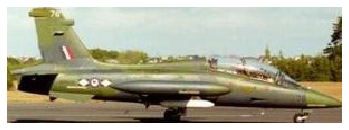

(104, 300, 3)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from os import walk
DATADIR = "Natural Images/data/natural_images"


f = []
for (dirpath, dirnames, filenames) in walk(DATADIR):
    f.extend(dirnames)
    break

for category in f:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        plt.imshow(img_array)  # graph it
        plt.axis("off")
        plt.show()  # display!

        break  # we just want one for now so break
    break
img_array.shape

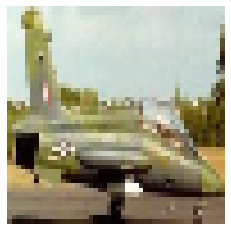

In [2]:
IMG_SIZE = 48

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.axis("off")
plt.show()


## 2) Load the Data

In [3]:
training_data = []

def create_training_data():
    for category in f: 

        path = os.path.join(DATADIR,category) 
        for img in tqdm(os.listdir(path)): 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE) 
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                training_data.append([new_array, category])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))


100%|███████████████████████████████████████████████████████████████████████████████| 986/986 [00:03<00:00, 253.04it/s]

6899


In [4]:
import random

random.shuffle(training_data)

In [5]:
for sample in training_data[:10]:
    print(sample[1])

motorbike
car
cat
car
dog
car
fruit
flower
fruit
car


## 3) Visualize the dataset

In [6]:
def show_batch(image_batch,label_batch): # see a batch of  the  data to better understand it
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        plt.title(label_batch[n])
        plt.axis("off")

6899
(6899, 1)
[['motorbike']
 ['car']
 ['cat']
 ...
 ['car']
 ['cat']
 ['car']]
(6899, 8) (6899, 48, 48, 1)


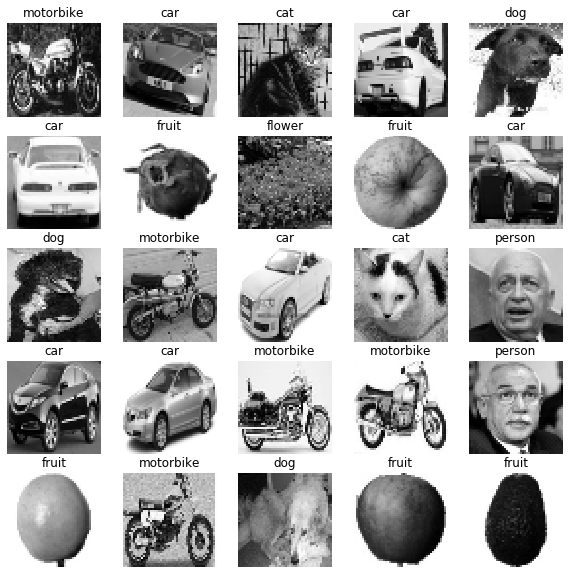

In [26]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

X = []
y = []
print(len(training_data))
for features,label in training_data:
    X.append(features)
    y.append(label)
show_batch(X,y)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y=np.array(y).reshape(-1, 1)
print(y.shape)
print(y)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

y=to_categorical(y)
print(y.shape,X.shape)

In [21]:
def show_batch_predicted(image_batch): # see the same batch after prediction from the model
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        pred=model.predict(np.array(image_batch[n]).reshape(1, IMG_SIZE, IMG_SIZE, 1))
        label=np.argmax(pred,axis=1)
        if label[0] == 0:
            plt.title(f[0])
        elif label[0] == 1:
            plt.title(f[1])
        elif label[0] == 2:
            plt.title(f[2])
        elif label[0] == 3:
            plt.title(f[3])
        elif label[0] == 4:
            plt.title(f[4])
        elif label[0] == 5:
            plt.title(f[5])
        elif label[0] == 6:
            plt.title(f[6])
        elif label[0] == 7:
            plt.title(f[7])
        plt.axis("off")

In [8]:
print(X.shape,y.shape)

(6899, 48, 48, 1) (6899, 8)


## 4) Correct for data imbalance

In [9]:
counts=[]
num_classes=8
for i in range(num_classes):
    counts.append(y[:,i].astype(bool).sum(axis=0))
counts

[727, 968, 885, 702, 843, 1000, 788, 986]

In [10]:
for i in range (num_classes):
    counts[i] = (1 / counts[i])*(len(X))/float(num_classes)

print(counts)
class_weight = {i: counts[i] for i in range(num_classes)}

[1.18621045392022, 0.89088326446281, 0.9744350282485876, 1.228454415954416, 1.0229833926453145, 0.862375, 1.0943845177664975, 0.8746196754563894]


## 5) Split the training data

In [11]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(X_train.shape)

(5519, 48, 48, 1)


## 6) Build the CNN

In [12]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Convolution2D,SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Input, Add
from keras.models import load_model, Model
# from keras.layers.merge import add

In [13]:
def conv_block(clf,filters,kernel_size):
    for i in range(2):
        clf=SeparableConv2D(filters=filters, kernel_size=kernel_size, padding='same')(clf)
        clf=BatchNormalization(epsilon=0.001)(clf)
        clf=LeakyReLU(alpha=0.1)(clf)
    return clf

def dense_block(clf,units, dropout_rate):
    
    clf=Dense(units,activation='relu')(clf)
    clf=BatchNormalization(epsilon=0.001)(clf)
    clf=Dropout(dropout_rate)(clf)
    
    return clf

In [27]:
def build_model():
    input_image = Input(shape=X_train.shape[1:])
    clf=Convolution2D(filters=64, kernel_size=3, padding='same')(input_image)
    clf=BatchNormalization(epsilon=0.001)(clf)
    clf=LeakyReLU(alpha=0.1)(clf)
    clf=Convolution2D(filters=64, kernel_size=3, padding='same')(input_image)
    clf=BatchNormalization(epsilon=0.001)(clf)
    clf=LeakyReLU(alpha=0.1)(clf)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=conv_block(clf,64,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=conv_block(clf,64,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=conv_block(clf,128,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=Convolution2D(filters=128, kernel_size=3, padding='same')(clf)
    clf=BatchNormalization(epsilon=0.001)(clf)
    clf=LeakyReLU(alpha=0.1)(clf)
    
    clf=conv_block(clf,128,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    

    clf=Convolution2D(filters=128, kernel_size=3, padding='same')(clf)
    clf=BatchNormalization(epsilon=0.001)(clf)
    clf=LeakyReLU(alpha=0.1)(clf)
    
    clf=Flatten()(clf)
    clf=dense_block(clf,128, 0.2)

    clf=Dense(8, activation='softmax')(clf)

    return Model(input_image,clf)
model=build_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_15 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
separable_conv2d_9 (Separabl (None, 24, 24, 64)        4736

## 7) Train the model

In [28]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping,LearningRateScheduler


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


checkpoint_cb = ModelCheckpoint("Natural_Images_classifier.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)


def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = LearningRateScheduler(exponential_decay_fn)

history = model.fit(
    X_train,y_train,
    epochs=100, batch_size=32,
    validation_split=.2,verbose=1, shuffle=True,
    callbacks=[checkpoint_cb, lr_scheduler],
    class_weight=class_weight
)

Train on 4415 samples, validate on 1104 samples
Epoch 1/100
4415/4415 [==============================] - 6s 1ms/step - loss: 1.5124 - accuracy: 0.4530 - val_loss: 2.7088 - val_accuracy: 0.1214
Epoch 2/100
 224/4415 [>.............................] - ETA: 2s - loss: 1.1186 - accuracy: 0.6161

C:\Users\ahmed\Anaconda3\envs\deeplearning_GPU\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


4415/4415 [==============================] - 3s 724us/step - loss: 0.9763 - accuracy: 0.6501 - val_loss: 2.7309 - val_accuracy: 0.2337
Epoch 3/100
4415/4415 [==============================] - 3s 721us/step - loss: 0.7527 - accuracy: 0.7255 - val_loss: 1.3969 - val_accuracy: 0.6757
Epoch 4/100
4415/4415 [==============================] - 3s 714us/step - loss: 0.6560 - accuracy: 0.7604 - val_loss: 1.0381 - val_accuracy: 0.7138
Epoch 5/100
4415/4415 [==============================] - 3s 716us/step - loss: 0.5527 - accuracy: 0.7948 - val_loss: 0.6849 - val_accuracy: 0.7790
Epoch 6/100
4415/4415 [==============================] - 3s 706us/step - loss: 0.5318 - accuracy: 0.8020 - val_loss: 0.6248 - val_accuracy: 0.7790
Epoch 7/100
4415/4415 [==============================] - 3s 725us/step - loss: 0.4894 - accuracy: 0.8152 - val_loss: 0.6618 - val_accuracy: 0.8342
Epoch 8/100
4415/4415 [==============================] - 3s 720us/step - loss: 0.4282 - accuracy: 0.8476 - val_loss: 0.8679 - val_

## 8) Visualizing model performance

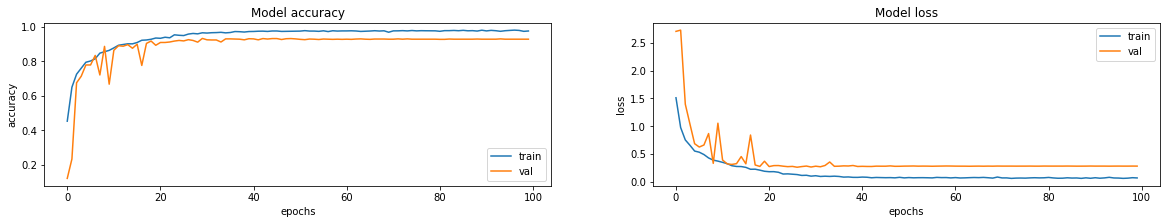

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 9) Predict and evaluate results

In [29]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

1380/1380 [==============================] - 0s 207us/step
Test loss: 0.2559779030473336
Test accuracy: 92.17391014099121


In [30]:
model.save('Natural_Images_classifier.h5')

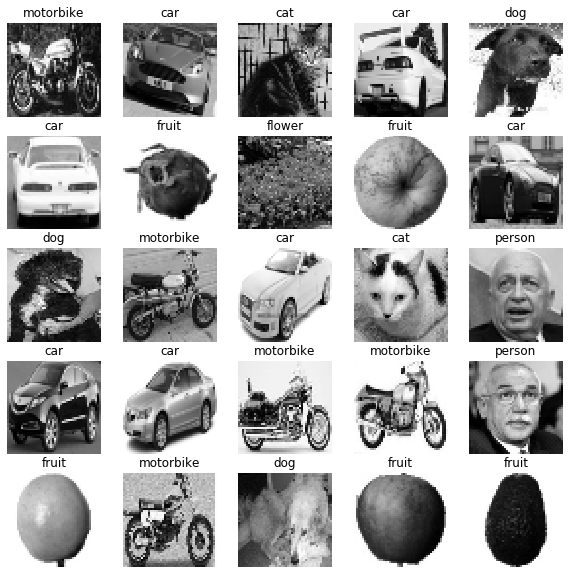

In [19]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
show_batch(X,y)

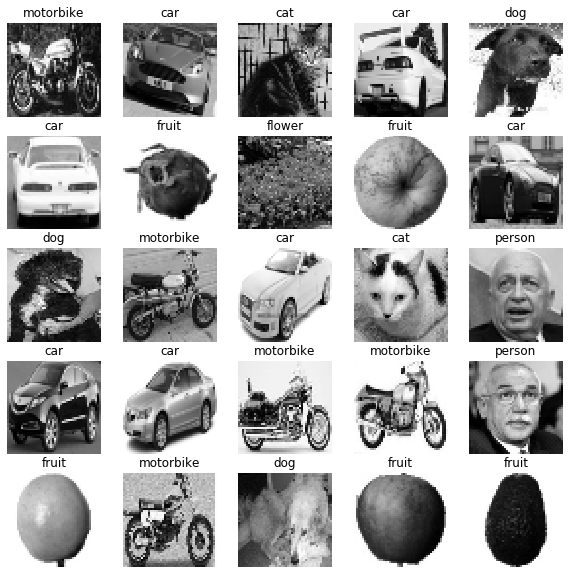

In [22]:
show_batch_predicted(X)